In [67]:
import numpy as np
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt

In [68]:
snr_ranges = list(range(-15,31,5))

# snr = -10log(sigma**2)
# sigma_sq = 10**(-snr/10)

sigma_list = []

for snr in snr_ranges:
    sigma_sq = 10**(-snr/10)
    sigma = sigma_sq**0.5
    sigma_list.append(sigma)

sigma_list

[5.623413251903491,
 3.1622776601683795,
 1.7782794100389228,
 1.0,
 0.5623413251903491,
 0.31622776601683794,
 0.17782794100389226,
 0.1,
 0.05623413251903491,
 0.03162277660168379]

In [69]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


## Single Example

In [70]:
N = 128
M = 20
sigma = 0.1

# Generate fixed H (measurement matrix)
H = np.random.normal(0, 1, size=(N, M))

# Generate a single sparse x
x_true = np.random.choice([-1, 1], size=M)

# Generate observed Y with Gaussian noise
noise = np.random.normal(0, sigma, N)
R = H @ x_true + noise  # Single observed data point

Y = np.zeros(len(R), dtype=int)  # Initialize Y as integer array
for i in range(len(R)):
    if R[i] >= 0:
        Y[i] = 1


stan_data = {
    "N": N,
    "M": M,
    "Y": Y,
    "H": H,
    "sigma": sigma,
}


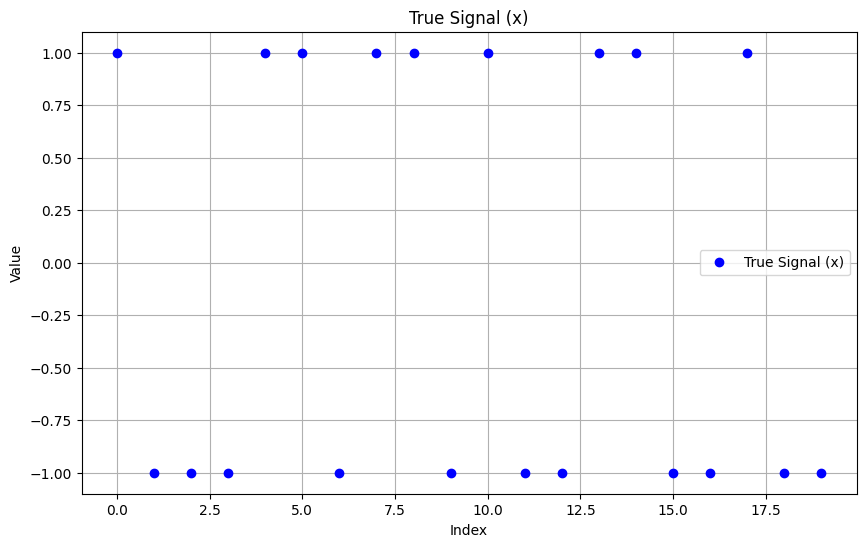

In [71]:
plt.figure(figsize=(10, 6))

# Plot x_true as points
plt.plot(range(M), x_true, 'bo', label='True Signal (x)')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('True Signal (x)')
plt.grid(True)
plt.legend()
plt.show()

In [73]:
model = CmdStanModel(stan_file='class.stan')
fit = model.sample(data=stan_data, chains=4, iter_warmup=1000, iter_sampling=1000, max_treedepth=15)


15:41:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


15:41:35 - cmdstanpy - INFO - CmdStan done processing.


In [74]:
posterior_samples = fit.draws_pd()

mean_x = np.array((posterior_samples.filter(like='x').mean()))
mean_x


array([ 1.13894552, -0.99721173, -0.84339779, -1.16311323,  0.81287953,
        1.20247875, -0.81538347,  0.81863405,  0.94002632, -0.75129132,
        1.1099047 , -1.28449996, -0.60350492,  1.08317091,  1.23019767,
       -1.19068534, -1.37156974,  0.99483682, -1.45528104, -1.0901222 ])

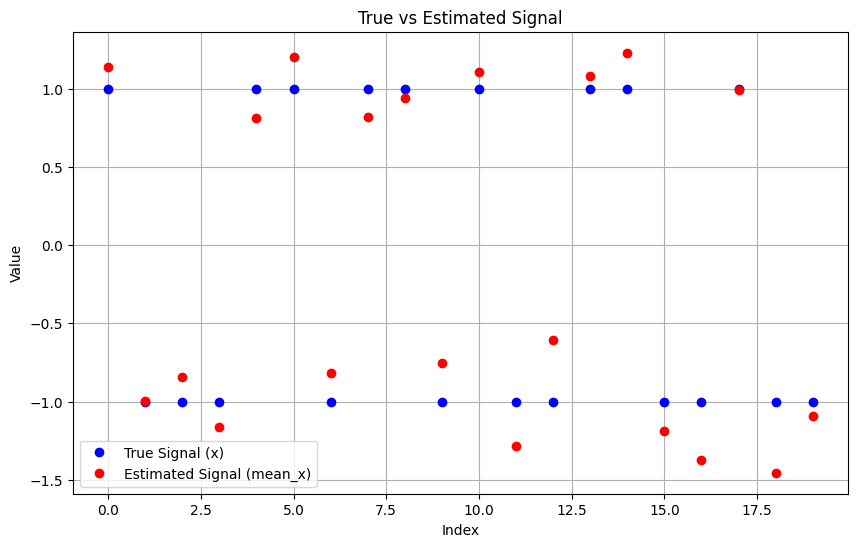

In [75]:
plt.figure(figsize=(10, 6))

# Plot x_true as points
plt.plot(range(M), x_true, 'bo', label='True Signal (x)')

# Plot mean_x as points
plt.plot(range(M), mean_x, 'ro', label='Estimated Signal (mean_x)')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('True vs Estimated Signal')
plt.grid(True)
plt.legend()
plt.show()

In [124]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-37.631400,0.084762,3.413390,-43.875100,-37.216600,-32.747800,1621.72,5516.04,1.001960
x[1],1.138950,0.006818,0.374617,0.542117,1.124890,1.788700,3019.23,10269.50,1.000870
x[2],-0.997212,0.006187,0.357342,-1.607860,-0.989932,-0.428592,3335.88,11346.50,0.999482
x[3],-0.843398,0.005372,0.333348,-1.393970,-0.842958,-0.302389,3850.16,13095.80,0.999759
x[4],-1.163110,0.006868,0.401013,-1.843690,-1.152690,-0.509429,3408.88,11594.80,1.000000
...,...,...,...,...,...,...,...,...,...
logits[124],0.427928,0.014107,1.175980,-1.476070,0.413392,2.400490,6949.30,23637.10,0.999828
logits[125],4.958130,0.024954,1.606690,2.405420,4.922560,7.675640,4145.54,14100.50,1.000010
logits[126],-1.129520,0.016300,1.237740,-3.234610,-1.104280,0.861116,5766.25,19613.10,0.999356
logits[127],-2.764510,0.019055,1.146490,-4.738900,-2.739590,-0.935126,3619.97,12312.80,1.000040


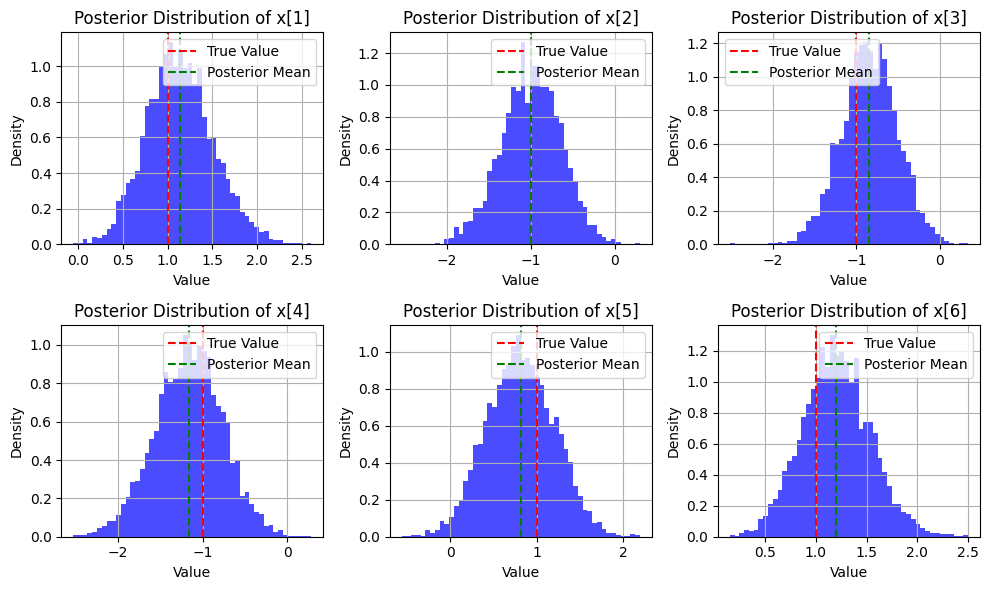

In [131]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))  # Changed to 2 rows, 3 columns

for i in range(1, 7):  # Loop from 1 to 6
    x_samples = posterior_samples[f'x[{i}]']  # Get samples for x[i]
    
    ax = axs[(i-1) // 3, (i-1) % 3]  # Updated to determine the subplot position for 2x3
    ax.hist(x_samples, bins=50, density=True, alpha=0.7, color='blue')
    ax.axvline(x=x_true[i-1], color='r', linestyle='--', label='True Value')  # Adjust index for x_true
    ax.axvline(x=mean_x[i-1], color='g', linestyle='--', label='Posterior Mean')  # Adjust index for mean_x
    
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.set_title(f'Posterior Distribution of x[{i}]')  # Update title for each plot
    ax.grid(True)
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [76]:
norm_diff_squared = np.sum((x_true - mean_x)**2)
norm_x_squared = np.sum(x_true**2)
NMSE = norm_diff_squared / norm_x_squared
NMSE_dB = 10 * np.log10(NMSE)

BER = np.sum(np.sign(mean_x) != np.sign(x_true)) / len(x_true)

NMSE, NMSE_dB, BER


(0.04894378549148269, -13.103024437606212, 0.0)

## NMSE and BER for multiple SNRs

In [102]:
def get_NMSE(N, M, sigma):
    H = np.random.normal(0, 1, size=(N, M))

    # Generate a single sparse x
    x_true = np.random.choice([-1, 1], size=M)

    # Generate observed Y with Gaussian noise
    noise = np.random.normal(0, sigma, N)
    R = H @ x_true + noise  # Single observed data point

    Y = np.zeros(len(R), dtype=int)  # Initialize Y as integer array
    for i in range(len(R)):
        if R[i] >= 0:
            Y[i] = 1


    stan_data = {
        "N": N,
        "M": M,
        "Y": Y,
        "H": H,
        "sigma": sigma,
    }

    model = CmdStanModel(stan_file='class.stan')
    fit = model.sample(data=stan_data, chains=4, iter_warmup=1000, iter_sampling=1000, max_treedepth=15)
    posterior_samples = fit.draws_pd()

    mean_x = np.array((posterior_samples.filter(like='x').mean()))

    norm_diff_squared = np.sum((x_true - mean_x)**2)
    norm_x_squared = np.sum(x_true**2)
    NMSE = norm_diff_squared / norm_x_squared
    NMSE_dB = 10 * np.log10(NMSE)

    BER = np.sum(np.sign(mean_x) != np.sign(x_true)) / len(x_true)

    return NMSE_dB, BER



In [99]:
NMSE_mean_dict = {}
NMSE_std_dict = {}  
BER_dict = {}
for sigma_i in range(len(snr_ranges)):
    NMSE_total = []
    BER_total = []
    K = 100                      # No. of iterations
    for i in range(K):
        NMSE, BER = get_NMSE(N=128, M=20, sigma=sigma_list[sigma_i])
        NMSE_total.append(NMSE)
        BER_total.append(BER)

    # Calculate mean and standard deviation for NMSE
    NMSE_mean_dict[snr_ranges[sigma_i]] = np.mean(NMSE_total)
    NMSE_std_dict[snr_ranges[sigma_i]] = np.std(NMSE_total)  # Calculate std dev
    BER_dict[snr_ranges[sigma_i]] = np.mean(BER_total)


21:56:54 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:56:55 - cmdstanpy - INFO - CmdStan done processing.
21:56:55 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:56:55 - cmdstanpy - INFO - CmdStan done processing.
21:56:55 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:56:55 - cmdstanpy - INFO - CmdStan done processing.
21:56:55 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:56:56 - cmdstanpy - INFO - CmdStan done processing.
21:56:56 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:56:56 - cmdstanpy - INFO - CmdStan done processing.
21:56:56 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:56:56 - cmdstanpy - INFO - CmdStan done processing.
21:56:56 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:56:56 - cmdstanpy - INFO - CmdStan done processing.
21:56:57 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:56:57 - cmdstanpy - INFO - CmdStan done processing.
21:56:57 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:56:57 - cmdstanpy - INFO - CmdStan done processing.
21:56:57 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:56:57 - cmdstanpy - INFO - CmdStan done processing.
21:56:58 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:56:58 - cmdstanpy - INFO - CmdStan done processing.
21:56:58 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:56:58 - cmdstanpy - INFO - CmdStan done processing.
21:56:58 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:56:58 - cmdstanpy - INFO - CmdStan done processing.
21:56:58 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:56:59 - cmdstanpy - INFO - CmdStan done processing.
21:56:59 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:56:59 - cmdstanpy - INFO - CmdStan done processing.
21:56:59 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:56:59 - cmdstanpy - INFO - CmdStan done processing.
21:56:59 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:56:59 - cmdstanpy - INFO - CmdStan done processing.
21:57:00 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:00 - cmdstanpy - INFO - CmdStan done processing.
21:57:00 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:00 - cmdstanpy - INFO - CmdStan done processing.
21:57:00 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:00 - cmdstanpy - INFO - CmdStan done processing.
21:57:01 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:01 - cmdstanpy - INFO - CmdStan done processing.


21:57:01 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:01 - cmdstanpy - INFO - CmdStan done processing.
21:57:01 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:01 - cmdstanpy - INFO - CmdStan done processing.
21:57:02 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:02 - cmdstanpy - INFO - CmdStan done processing.
21:57:02 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:02 - cmdstanpy - INFO - CmdStan done processing.
21:57:02 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:02 - cmdstanpy - INFO - CmdStan done processing.
21:57:03 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:03 - cmdstanpy - INFO - CmdStan done processing.
21:57:03 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:03 - cmdstanpy - INFO - CmdStan done processing.
21:57:03 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:03 - cmdstanpy - INFO - CmdStan done processing.
21:57:03 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:04 - cmdstanpy - INFO - CmdStan done processing.
21:57:04 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:04 - cmdstanpy - INFO - CmdStan done processing.
21:57:04 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:04 - cmdstanpy - INFO - CmdStan done processing.
21:57:04 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:05 - cmdstanpy - INFO - CmdStan done processing.
21:57:05 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:05 - cmdstanpy - INFO - CmdStan done processing.
21:57:05 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:05 - cmdstanpy - INFO - CmdStan done processing.
21:57:05 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:05 - cmdstanpy - INFO - CmdStan done processing.
21:57:06 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:06 - cmdstanpy - INFO - CmdStan done processing.
21:57:06 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:06 - cmdstanpy - INFO - CmdStan done processing.
21:57:06 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:06 - cmdstanpy - INFO - CmdStan done processing.
21:57:07 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:07 - cmdstanpy - INFO - CmdStan done processing.
21:57:07 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:07 - cmdstanpy - INFO - CmdStan done processing.
21:57:07 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:07 - cmdstanpy - INFO - CmdStan done processing.
21:57:08 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:08 - cmdstanpy - INFO - CmdStan done processing.
21:57:08 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:08 - cmdstanpy - INFO - CmdStan done processing.
21:57:08 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:08 - cmdstanpy - INFO - CmdStan done processing.
21:57:08 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:09 - cmdstanpy - INFO - CmdStan done processing.
21:57:09 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                     


21:57:09 - cmdstanpy - INFO - CmdStan done processing.
21:57:09 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:09 - cmdstanpy - INFO - CmdStan done processing.
21:57:09 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:10 - cmdstanpy - INFO - CmdStan done processing.
21:57:10 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:10 - cmdstanpy - INFO - CmdStan done processing.
21:57:10 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:10 - cmdstanpy - INFO - CmdStan done processing.
21:57:10 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:11 - cmdstanpy - INFO - CmdStan done processing.
21:57:11 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:11 - cmdstanpy - INFO - CmdStan done processing.
21:57:11 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:11 - cmdstanpy - INFO - CmdStan done processing.


21:57:12 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:12 - cmdstanpy - INFO - CmdStan done processing.
21:57:12 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:12 - cmdstanpy - INFO - CmdStan done processing.
21:57:12 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:12 - cmdstanpy - INFO - CmdStan done processing.
21:57:13 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:13 - cmdstanpy - INFO - CmdStan done processing.
21:57:13 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:13 - cmdstanpy - INFO - CmdStan done processing.
21:57:13 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:13 - cmdstanpy - INFO - CmdStan done processing.
21:57:13 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:14 - cmdstanpy - INFO - CmdStan done processing.
21:57:14 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


21:57:14 - cmdstanpy - INFO - CmdStan done processing.
21:57:14 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:14 - cmdstanpy - INFO - CmdStan done processing.
21:57:15 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:15 - cmdstanpy - INFO - CmdStan done processing.
21:57:15 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:15 - cmdstanpy - INFO - CmdStan done processing.
21:57:15 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:15 - cmdstanpy - INFO - CmdStan done processing.
21:57:15 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:16 - cmdstanpy - INFO - CmdStan done processing.
21:57:16 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:16 - cmdstanpy - INFO - CmdStan done processing.
21:57:16 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:16 - cmdstanpy - INFO - CmdStan done processing.
21:57:16 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:16 - cmdstanpy - INFO - CmdStan done processing.
21:57:17 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:17 - cmdstanpy - INFO - CmdStan done processing.
21:57:17 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:17 - cmdstanpy - INFO - CmdStan done processing.
21:57:17 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:17 - cmdstanpy - INFO - CmdStan done processing.
21:57:18 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:18 - cmdstanpy - INFO - CmdStan done processing.
21:57:18 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:18 - cmdstanpy - INFO - CmdStan done processing.
21:57:18 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:18 - cmdstanpy - INFO - CmdStan done processing.
21:57:18 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:18 - cmdstanpy - INFO - CmdStan done processing.
21:57:19 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:19 - cmdstanpy - INFO - CmdStan done processing.
21:57:19 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:19 - cmdstanpy - INFO - CmdStan done processing.
21:57:19 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:19 - cmdstanpy - INFO - CmdStan done processing.
21:57:20 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:20 - cmdstanpy - INFO - CmdStan done processing.
21:57:20 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:20 - cmdstanpy - INFO - CmdStan done processing.
21:57:20 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:20 - cmdstanpy - INFO - CmdStan done processing.
21:57:20 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:20 - cmdstanpy - INFO - CmdStan done processing.
21:57:21 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:21 - cmdstanpy - INFO - CmdStan done processing.
21:57:21 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:21 - cmdstanpy - INFO - CmdStan done processing.
21:57:21 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:21 - cmdstanpy - INFO - CmdStan done processing.
21:57:22 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:22 - cmdstanpy - INFO - CmdStan done processing.
21:57:22 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:22 - cmdstanpy - INFO - CmdStan done processing.
21:57:22 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:22 - cmdstanpy - INFO - CmdStan done processing.
21:57:22 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:23 - cmdstanpy - INFO - CmdStan done processing.
21:57:23 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:23 - cmdstanpy - INFO - CmdStan done processing.
21:57:23 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:23 - cmdstanpy - INFO - CmdStan done processing.
21:57:23 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:23 - cmdstanpy - INFO - CmdStan done processing.
21:57:24 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:24 - cmdstanpy - INFO - CmdStan done processing.
21:57:24 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:24 - cmdstanpy - INFO - CmdStan done processing.
21:57:24 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:24 - cmdstanpy - INFO - CmdStan done processing.
21:57:24 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:25 - cmdstanpy - INFO - CmdStan done processing.
21:57:25 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:25 - cmdstanpy - INFO - CmdStan done processing.
21:57:25 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:25 - cmdstanpy - INFO - CmdStan done processing.
21:57:25 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:25 - cmdstanpy - INFO - CmdStan done processing.
21:57:26 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:26 - cmdstanpy - INFO - CmdStan done processing.
21:57:26 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:26 - cmdstanpy - INFO - CmdStan done processing.
21:57:26 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:26 - cmdstanpy - INFO - CmdStan done processing.
21:57:26 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:27 - cmdstanpy - INFO - CmdStan done processing.
21:57:27 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:27 - cmdstanpy - INFO - CmdStan done processing.
21:57:27 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:27 - cmdstanpy - INFO - CmdStan done processing.
21:57:27 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:27 - cmdstanpy - INFO - CmdStan done processing.
21:57:28 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:28 - cmdstanpy - INFO - CmdStan done processing.
21:57:28 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:28 - cmdstanpy - INFO - CmdStan done processing.
21:57:28 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:28 - cmdstanpy - INFO - CmdStan done processing.
21:57:28 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:29 - cmdstanpy - INFO - CmdStan done processing.
21:57:29 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:29 - cmdstanpy - INFO - CmdStan done processing.
21:57:29 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:29 - cmdstanpy - INFO - CmdStan done processing.
21:57:29 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:30 - cmdstanpy - INFO - CmdStan done processing.
21:57:30 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:30 - cmdstanpy - INFO - CmdStan done processing.
21:57:30 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:30 - cmdstanpy - INFO - CmdStan done processing.
21:57:30 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:30 - cmdstanpy - INFO - CmdStan done processing.
21:57:31 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:31 - cmdstanpy - INFO - CmdStan done processing.
21:57:31 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:31 - cmdstanpy - INFO - CmdStan done processing.
21:57:31 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:31 - cmdstanpy - INFO - CmdStan done processing.
21:57:31 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:32 - cmdstanpy - INFO - CmdStan done processing.
21:57:32 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:32 - cmdstanpy - INFO - CmdStan done processing.
21:57:32 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:32 - cmdstanpy - INFO - CmdStan done processing.
21:57:32 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:33 - cmdstanpy - INFO - CmdStan done processing.
21:57:33 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:33 - cmdstanpy - INFO - CmdStan done processing.
21:57:33 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:33 - cmdstanpy - INFO - CmdStan done processing.


21:57:33 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:34 - cmdstanpy - INFO - CmdStan done processing.
21:57:34 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:34 - cmdstanpy - INFO - CmdStan done processing.
21:57:34 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:34 - cmdstanpy - INFO - CmdStan done processing.
21:57:34 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:34 - cmdstanpy - INFO - CmdStan done processing.
21:57:35 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:35 - cmdstanpy - INFO - CmdStan done processing.
21:57:35 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:35 - cmdstanpy - INFO - CmdStan done processing.
21:57:35 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:35 - cmdstanpy - INFO - CmdStan done processing.


21:57:36 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:36 - cmdstanpy - INFO - CmdStan done processing.
21:57:36 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:36 - cmdstanpy - INFO - CmdStan done processing.
21:57:36 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:37 - cmdstanpy - INFO - CmdStan done processing.
21:57:37 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:37 - cmdstanpy - INFO - CmdStan done processing.


21:57:37 - cmdstanpy - INFO - CmdStan start processing






















































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:37 - cmdstanpy - INFO - CmdStan done processing.


21:57:38 - cmdstanpy - INFO - CmdStan start processing











































































chain 1 |██████████| 00:00 Sampling completed                       




chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:38 - cmdstanpy - INFO - CmdStan done processing.


21:57:39 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:39 - cmdstanpy - INFO - CmdStan done processing.
21:57:39 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:39 - cmdstanpy - INFO - CmdStan done processing.
21:57:39 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:39 - cmdstanpy - INFO - CmdStan done processing.
21:57:40 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:40 - cmdstanpy - INFO - CmdStan done processing.
21:57:40 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:40 - cmdstanpy - INFO - CmdStan done processing.
21:57:40 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:40 - cmdstanpy - INFO - CmdStan done processing.
21:57:40 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:41 - cmdstanpy - INFO - CmdStan done processing.
21:57:41 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:41 - cmdstanpy - INFO - CmdStan done processing.
21:57:41 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:41 - cmdstanpy - INFO - CmdStan done processing.
21:57:41 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:41 - cmdstanpy - INFO - CmdStan done processing.
21:57:42 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:42 - cmdstanpy - INFO - CmdStan done processing.
21:57:42 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:42 - cmdstanpy - INFO - CmdStan done processing.
21:57:42 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:42 - cmdstanpy - INFO - CmdStan done processing.
21:57:43 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:43 - cmdstanpy - INFO - CmdStan done processing.
21:57:43 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:43 - cmdstanpy - INFO - CmdStan done processing.


21:57:43 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:43 - cmdstanpy - INFO - CmdStan done processing.


21:57:44 - cmdstanpy - INFO - CmdStan start processing









































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:44 - cmdstanpy - INFO - CmdStan done processing.


21:57:45 - cmdstanpy - INFO - CmdStan start processing




































































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:45 - cmdstanpy - INFO - CmdStan done processing.


21:57:45 - cmdstanpy - INFO - CmdStan start processing











































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:46 - cmdstanpy - INFO - CmdStan done processing.


21:57:46 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:46 - cmdstanpy - INFO - CmdStan done processing.


21:57:47 - cmdstanpy - INFO - CmdStan start processing















































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:47 - cmdstanpy - INFO - CmdStan done processing.
21:57:47 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:47 - cmdstanpy - INFO - CmdStan done processing.
21:57:47 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:48 - cmdstanpy - INFO - CmdStan done processing.


21:57:48 - cmdstanpy - INFO - CmdStan start processing

















































































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:49 - cmdstanpy - INFO - CmdStan done processing.
21:57:49 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:49 - cmdstanpy - INFO - CmdStan done processing.
21:57:49 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:49 - cmdstanpy - INFO - CmdStan done processing.
21:57:50 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:50 - cmdstanpy - INFO - CmdStan done processing.
21:57:50 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:50 - cmdstanpy - INFO - CmdStan done processing.
21:57:50 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:50 - cmdstanpy - INFO - CmdStan done processing.
21:57:50 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:51 - cmdstanpy - INFO - CmdStan done processing.
21:57:51 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:51 - cmdstanpy - INFO - CmdStan done processing.
21:57:51 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:51 - cmdstanpy - INFO - CmdStan done processing.
21:57:51 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:52 - cmdstanpy - INFO - CmdStan done processing.
21:57:52 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:52 - cmdstanpy - INFO - CmdStan done processing.
21:57:52 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:52 - cmdstanpy - INFO - CmdStan done processing.
21:57:52 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:52 - cmdstanpy - INFO - CmdStan done processing.
21:57:53 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:53 - cmdstanpy - INFO - CmdStan done processing.
21:57:53 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:53 - cmdstanpy - INFO - CmdStan done processing.
21:57:53 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:53 - cmdstanpy - INFO - CmdStan done processing.
21:57:53 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:54 - cmdstanpy - INFO - CmdStan done processing.
21:57:54 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:54 - cmdstanpy - INFO - CmdStan done processing.
21:57:54 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:54 - cmdstanpy - INFO - CmdStan done processing.
21:57:54 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:54 - cmdstanpy - INFO - CmdStan done processing.
21:57:55 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:55 - cmdstanpy - INFO - CmdStan done processing.
21:57:55 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:55 - cmdstanpy - INFO - CmdStan done processing.
21:57:55 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:55 - cmdstanpy - INFO - CmdStan done processing.
21:57:55 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:56 - cmdstanpy - INFO - CmdStan done processing.
21:57:56 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:56 - cmdstanpy - INFO - CmdStan done processing.
21:57:56 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:56 - cmdstanpy - INFO - CmdStan done processing.


21:57:56 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:57 - cmdstanpy - INFO - CmdStan done processing.
21:57:57 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:57 - cmdstanpy - INFO - CmdStan done processing.
21:57:57 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:57 - cmdstanpy - INFO - CmdStan done processing.
21:57:57 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:58 - cmdstanpy - INFO - CmdStan done processing.
21:57:58 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:58 - cmdstanpy - INFO - CmdStan done processing.
21:57:58 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:58 - cmdstanpy - INFO - CmdStan done processing.
21:57:58 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:58 - cmdstanpy - INFO - CmdStan done processing.
21:57:59 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:59 - cmdstanpy - INFO - CmdStan done processing.
21:57:59 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:59 - cmdstanpy - INFO - CmdStan done processing.
21:57:59 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:57:59 - cmdstanpy - INFO - CmdStan done processing.
21:58:00 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:00 - cmdstanpy - INFO - CmdStan done processing.
21:58:00 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:00 - cmdstanpy - INFO - CmdStan done processing.
21:58:00 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:00 - cmdstanpy - INFO - CmdStan done processing.
21:58:00 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:01 - cmdstanpy - INFO - CmdStan done processing.
21:58:01 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:01 - cmdstanpy - INFO - CmdStan done processing.
21:58:01 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:01 - cmdstanpy - INFO - CmdStan done processing.
21:58:01 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:01 - cmdstanpy - INFO - CmdStan done processing.
21:58:02 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:02 - cmdstanpy - INFO - CmdStan done processing.
21:58:02 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:02 - cmdstanpy - INFO - CmdStan done processing.
21:58:02 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:02 - cmdstanpy - INFO - CmdStan done processing.
21:58:02 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:03 - cmdstanpy - INFO - CmdStan done processing.
21:58:03 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:03 - cmdstanpy - INFO - CmdStan done processing.
21:58:03 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:03 - cmdstanpy - INFO - CmdStan done processing.
21:58:03 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:04 - cmdstanpy - INFO - CmdStan done processing.
21:58:04 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:04 - cmdstanpy - INFO - CmdStan done processing.


21:58:04 - cmdstanpy - INFO - CmdStan start processing





































































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:05 - cmdstanpy - INFO - CmdStan done processing.
21:58:05 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:05 - cmdstanpy - INFO - CmdStan done processing.
21:58:05 - cmdstanpy - INFO - CmdStan start processing















































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:06 - cmdstanpy - INFO - CmdStan done processing.


21:58:06 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:06 - cmdstanpy - INFO - CmdStan done processing.
21:58:06 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:06 - cmdstanpy - INFO - CmdStan done processing.
21:58:06 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:07 - cmdstanpy - INFO - CmdStan done processing.
21:58:07 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:07 - cmdstanpy - INFO - CmdStan done processing.
21:58:07 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:07 - cmdstanpy - INFO - CmdStan done processing.
21:58:07 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:08 - cmdstanpy - INFO - CmdStan done processing.
21:58:08 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:08 - cmdstanpy - INFO - CmdStan done processing.
21:58:08 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:08 - cmdstanpy - INFO - CmdStan done processing.
21:58:08 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:08 - cmdstanpy - INFO - CmdStan done processing.
21:58:09 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:09 - cmdstanpy - INFO - CmdStan done processing.
21:58:09 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:09 - cmdstanpy - INFO - CmdStan done processing.
21:58:09 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:09 - cmdstanpy - INFO - CmdStan done processing.
21:58:09 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:10 - cmdstanpy - INFO - CmdStan done processing.
21:58:10 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:10 - cmdstanpy - INFO - CmdStan done processing.
21:58:10 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:10 - cmdstanpy - INFO - CmdStan done processing.
21:58:10 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:11 - cmdstanpy - INFO - CmdStan done processing.
21:58:11 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:11 - cmdstanpy - INFO - CmdStan done processing.
21:58:11 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:11 - cmdstanpy - INFO - CmdStan done processing.
21:58:11 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:12 - cmdstanpy - INFO - CmdStan done processing.
21:58:12 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:12 - cmdstanpy - INFO - CmdStan done processing.
21:58:12 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:12 - cmdstanpy - INFO - CmdStan done processing.
21:58:12 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:12 - cmdstanpy - INFO - CmdStan done processing.
21:58:13 - cmdstanpy - INFO - CmdStan start processing
























































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                       





chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                       


21:58:13 - cmdstanpy - INFO - CmdStan done processing.
21:58:13 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:13 - cmdstanpy - INFO - CmdStan done processing.
21:58:13 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:14 - cmdstanpy - INFO - CmdStan done processing.
21:58:14 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:14 - cmdstanpy - INFO - CmdStan done processing.
21:58:14 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:14 - cmdstanpy - INFO - CmdStan done processing.
21:58:14 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:14 - cmdstanpy - INFO - CmdStan done processing.


21:58:15 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:15 - cmdstanpy - INFO - CmdStan done processing.
21:58:15 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:15 - cmdstanpy - INFO - CmdStan done processing.
21:58:15 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:16 - cmdstanpy - INFO - CmdStan done processing.
21:58:16 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:16 - cmdstanpy - INFO - CmdStan done processing.
21:58:16 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:16 - cmdstanpy - INFO - CmdStan done processing.
21:58:16 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:16 - cmdstanpy - INFO - CmdStan done processing.
21:58:17 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:17 - cmdstanpy - INFO - CmdStan done processing.
21:58:17 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:17 - cmdstanpy - INFO - CmdStan done processing.
21:58:17 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:17 - cmdstanpy - INFO - CmdStan done processing.
21:58:18 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:18 - cmdstanpy - INFO - CmdStan done processing.
21:58:18 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:18 - cmdstanpy - INFO - CmdStan done processing.


21:58:18 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:18 - cmdstanpy - INFO - CmdStan done processing.


21:58:19 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:19 - cmdstanpy - INFO - CmdStan done processing.
21:58:19 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:19 - cmdstanpy - INFO - CmdStan done processing.
21:58:19 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:19 - cmdstanpy - INFO - CmdStan done processing.
21:58:20 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:20 - cmdstanpy - INFO - CmdStan done processing.
21:58:20 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:20 - cmdstanpy - INFO - CmdStan done processing.
21:58:20 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:20 - cmdstanpy - INFO - CmdStan done processing.
21:58:20 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:21 - cmdstanpy - INFO - CmdStan done processing.
21:58:21 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:21 - cmdstanpy - INFO - CmdStan done processing.
21:58:21 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:21 - cmdstanpy - INFO - CmdStan done processing.
21:58:21 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:21 - cmdstanpy - INFO - CmdStan done processing.
21:58:22 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:22 - cmdstanpy - INFO - CmdStan done processing.
21:58:22 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:22 - cmdstanpy - INFO - CmdStan done processing.
21:58:22 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:22 - cmdstanpy - INFO - CmdStan done processing.
21:58:23 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:23 - cmdstanpy - INFO - CmdStan done processing.
21:58:23 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:23 - cmdstanpy - INFO - CmdStan done processing.
21:58:23 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:23 - cmdstanpy - INFO - CmdStan done processing.
21:58:23 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:24 - cmdstanpy - INFO - CmdStan done processing.
21:58:24 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:24 - cmdstanpy - INFO - CmdStan done processing.
21:58:24 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:24 - cmdstanpy - INFO - CmdStan done processing.
21:58:24 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:24 - cmdstanpy - INFO - CmdStan done processing.
21:58:25 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:25 - cmdstanpy - INFO - CmdStan done processing.
21:58:25 - cmdstanpy - INFO - CmdStan start processing
























































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:25 - cmdstanpy - INFO - CmdStan done processing.
21:58:25 - cmdstanpy - INFO - CmdStan start processing





















































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:26 - cmdstanpy - INFO - CmdStan done processing.
21:58:26 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:26 - cmdstanpy - INFO - CmdStan done processing.
21:58:26 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:26 - cmdstanpy - INFO - CmdStan done processing.
21:58:27 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:27 - cmdstanpy - INFO - CmdStan done processing.
21:58:27 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:27 - cmdstanpy - INFO - CmdStan done processing.
21:58:27 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:27 - cmdstanpy - INFO - CmdStan done processing.
21:58:27 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:28 - cmdstanpy - INFO - CmdStan done processing.
21:58:28 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:28 - cmdstanpy - INFO - CmdStan done processing.
21:58:28 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:28 - cmdstanpy - INFO - CmdStan done processing.
21:58:28 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:28 - cmdstanpy - INFO - CmdStan done processing.
21:58:29 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:29 - cmdstanpy - INFO - CmdStan done processing.
21:58:29 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:29 - cmdstanpy - INFO - CmdStan done processing.
21:58:29 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:29 - cmdstanpy - INFO - CmdStan done processing.
21:58:29 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:30 - cmdstanpy - INFO - CmdStan done processing.
21:58:30 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:30 - cmdstanpy - INFO - CmdStan done processing.
21:58:30 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:30 - cmdstanpy - INFO - CmdStan done processing.
21:58:30 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:31 - cmdstanpy - INFO - CmdStan done processing.
21:58:31 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:31 - cmdstanpy - INFO - CmdStan done processing.
21:58:31 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:31 - cmdstanpy - INFO - CmdStan done processing.
21:58:31 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:31 - cmdstanpy - INFO - CmdStan done processing.
21:58:32 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:32 - cmdstanpy - INFO - CmdStan done processing.
21:58:32 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:32 - cmdstanpy - INFO - CmdStan done processing.
21:58:32 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:32 - cmdstanpy - INFO - CmdStan done processing.
21:58:32 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:33 - cmdstanpy - INFO - CmdStan done processing.
21:58:33 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:33 - cmdstanpy - INFO - CmdStan done processing.
21:58:33 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:33 - cmdstanpy - INFO - CmdStan done processing.
21:58:33 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:33 - cmdstanpy - INFO - CmdStan done processing.
21:58:34 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:34 - cmdstanpy - INFO - CmdStan done processing.
21:58:34 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:34 - cmdstanpy - INFO - CmdStan done processing.
21:58:34 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:34 - cmdstanpy - INFO - CmdStan done processing.
21:58:34 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:35 - cmdstanpy - INFO - CmdStan done processing.
21:58:35 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:35 - cmdstanpy - INFO - CmdStan done processing.


21:58:35 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:35 - cmdstanpy - INFO - CmdStan done processing.
21:58:35 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:36 - cmdstanpy - INFO - CmdStan done processing.
21:58:36 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:36 - cmdstanpy - INFO - CmdStan done processing.
21:58:36 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:36 - cmdstanpy - INFO - CmdStan done processing.


21:58:37 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:37 - cmdstanpy - INFO - CmdStan done processing.
21:58:37 - cmdstanpy - INFO - CmdStan start processing
























































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:38 - cmdstanpy - INFO - CmdStan done processing.


21:58:38 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:38 - cmdstanpy - INFO - CmdStan done processing.


21:58:38 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:38 - cmdstanpy - INFO - CmdStan done processing.
21:58:39 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:39 - cmdstanpy - INFO - CmdStan done processing.
21:58:39 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:39 - cmdstanpy - INFO - CmdStan done processing.
21:58:39 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:39 - cmdstanpy - INFO - CmdStan done processing.
21:58:39 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:40 - cmdstanpy - INFO - CmdStan done processing.
21:58:40 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:40 - cmdstanpy - INFO - CmdStan done processing.
21:58:40 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:40 - cmdstanpy - INFO - CmdStan done processing.
21:58:40 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:40 - cmdstanpy - INFO - CmdStan done processing.
21:58:41 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:41 - cmdstanpy - INFO - CmdStan done processing.
21:58:41 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:41 - cmdstanpy - INFO - CmdStan done processing.
21:58:41 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:41 - cmdstanpy - INFO - CmdStan done processing.
21:58:41 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:42 - cmdstanpy - INFO - CmdStan done processing.
21:58:42 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:42 - cmdstanpy - INFO - CmdStan done processing.
21:58:42 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:42 - cmdstanpy - INFO - CmdStan done processing.
21:58:42 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:42 - cmdstanpy - INFO - CmdStan done processing.
21:58:43 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:43 - cmdstanpy - INFO - CmdStan done processing.
21:58:43 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:43 - cmdstanpy - INFO - CmdStan done processing.
21:58:43 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:43 - cmdstanpy - INFO - CmdStan done processing.
21:58:44 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:44 - cmdstanpy - INFO - CmdStan done processing.
21:58:44 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:44 - cmdstanpy - INFO - CmdStan done processing.
21:58:44 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:44 - cmdstanpy - INFO - CmdStan done processing.
21:58:44 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:45 - cmdstanpy - INFO - CmdStan done processing.
21:58:45 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:45 - cmdstanpy - INFO - CmdStan done processing.
21:58:45 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:45 - cmdstanpy - INFO - CmdStan done processing.
21:58:45 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:45 - cmdstanpy - INFO - CmdStan done processing.
21:58:46 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:46 - cmdstanpy - INFO - CmdStan done processing.
21:58:46 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:46 - cmdstanpy - INFO - CmdStan done processing.
21:58:46 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:47 - cmdstanpy - INFO - CmdStan done processing.
21:58:47 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:47 - cmdstanpy - INFO - CmdStan done processing.
21:58:47 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:47 - cmdstanpy - INFO - CmdStan done processing.
21:58:47 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:47 - cmdstanpy - INFO - CmdStan done processing.
21:58:48 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:48 - cmdstanpy - INFO - CmdStan done processing.
21:58:48 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:48 - cmdstanpy - INFO - CmdStan done processing.
21:58:48 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:48 - cmdstanpy - INFO - CmdStan done processing.
21:58:48 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:49 - cmdstanpy - INFO - CmdStan done processing.
21:58:49 - cmdstanpy - INFO - CmdStan start processing




















chain 1 |██████████| 5:59:52 Iteration: 2000 / 2000 [100%]  (Sampling)












chain 2 |██████████| 5:59:52 Iteration: 2000 / 2000 [100%]  (Sampling)
chain 3 |██████████| 5:59:52 Iteration: 2000 / 2000 [100%]  (Sampling)
chain 4 |██████████| 5:59:52 Iteration: 2000 / 2000 [100%]  (Sampling)
























chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:49 - cmdstanpy - INFO - CmdStan done processing.
21:58:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:49 - cmdstanpy - INFO - CmdStan done processing.
21:58:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:50 - cmdstanpy - INFO - CmdStan done processing.
21:58:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:50 - cmdstanpy - INFO - CmdStan done processing.
21:58:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:50 - cmdstanpy - INFO - CmdStan done processing.
21:58:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:51 - cmdstanpy - INFO - CmdStan done processing.
21:58:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:51 - cmdstanpy - INFO - CmdStan done processing.
21:58:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:51 - cmdstanpy - INFO - CmdStan done processing.
21:58:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:51 - cmdstanpy - INFO - CmdStan done processing.
21:58:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:52 - cmdstanpy - INFO - CmdStan done processing.
21:58:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:52 - cmdstanpy - INFO - CmdStan done processing.
21:58:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:52 - cmdstanpy - INFO - CmdStan done processing.
21:58:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:53 - cmdstanpy - INFO - CmdStan done processing.
21:58:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:53 - cmdstanpy - INFO - CmdStan done processing.
21:58:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:53 - cmdstanpy - INFO - CmdStan done processing.
21:58:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:54 - cmdstanpy - INFO - CmdStan done processing.
21:58:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:54 - cmdstanpy - INFO - CmdStan done processing.
21:58:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:54 - cmdstanpy - INFO - CmdStan done processing.


21:58:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:55 - cmdstanpy - INFO - CmdStan done processing.
21:58:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:55 - cmdstanpy - INFO - CmdStan done processing.
21:58:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:55 - cmdstanpy - INFO - CmdStan done processing.
21:58:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:56 - cmdstanpy - INFO - CmdStan done processing.
21:58:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:56 - cmdstanpy - INFO - CmdStan done processing.
21:58:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:56 - cmdstanpy - INFO - CmdStan done processing.
21:58:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:56 - cmdstanpy - INFO - CmdStan done processing.
21:58:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:57 - cmdstanpy - INFO - CmdStan done processing.
21:58:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:57 - cmdstanpy - INFO - CmdStan done processing.
21:58:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:57 - cmdstanpy - INFO - CmdStan done processing.
21:58:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:58 - cmdstanpy - INFO - CmdStan done processing.
21:58:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:58 - cmdstanpy - INFO - CmdStan done processing.
21:58:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:58 - cmdstanpy - INFO - CmdStan done processing.
21:58:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:59 - cmdstanpy - INFO - CmdStan done processing.
21:58:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:59 - cmdstanpy - INFO - CmdStan done processing.
21:58:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:59 - cmdstanpy - INFO - CmdStan done processing.
21:58:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:58:59 - cmdstanpy - INFO - CmdStan done processing.
21:59:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:00 - cmdstanpy - INFO - CmdStan done processing.
21:59:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:00 - cmdstanpy - INFO - CmdStan done processing.
21:59:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:00 - cmdstanpy - INFO - CmdStan done processing.
21:59:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:01 - cmdstanpy - INFO - CmdStan done processing.
21:59:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:01 - cmdstanpy - INFO - CmdStan done processing.
21:59:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:01 - cmdstanpy - INFO - CmdStan done processing.
21:59:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:02 - cmdstanpy - INFO - CmdStan done processing.
21:59:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:02 - cmdstanpy - INFO - CmdStan done processing.
21:59:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:02 - cmdstanpy - INFO - CmdStan done processing.
21:59:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:02 - cmdstanpy - INFO - CmdStan done processing.
21:59:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:03 - cmdstanpy - INFO - CmdStan done processing.
21:59:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:03 - cmdstanpy - INFO - CmdStan done processing.
21:59:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:03 - cmdstanpy - INFO - CmdStan done processing.
21:59:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:04 - cmdstanpy - INFO - CmdStan done processing.
21:59:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:04 - cmdstanpy - INFO - CmdStan done processing.
21:59:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:04 - cmdstanpy - INFO - CmdStan done processing.
21:59:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:05 - cmdstanpy - INFO - CmdStan done processing.
21:59:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:05 - cmdstanpy - INFO - CmdStan done processing.
21:59:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:05 - cmdstanpy - INFO - CmdStan done processing.
21:59:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

21:59:06 - cmdstanpy - INFO - CmdStan done processing.


21:59:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:06 - cmdstanpy - INFO - CmdStan done processing.
21:59:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:06 - cmdstanpy - INFO - CmdStan done processing.
21:59:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:06 - cmdstanpy - INFO - CmdStan done processing.
21:59:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:07 - cmdstanpy - INFO - CmdStan done processing.
21:59:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:07 - cmdstanpy - INFO - CmdStan done processing.
21:59:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:07 - cmdstanpy - INFO - CmdStan done processing.
21:59:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:08 - cmdstanpy - INFO - CmdStan done processing.
21:59:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:08 - cmdstanpy - INFO - CmdStan done processing.
21:59:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:08 - cmdstanpy - INFO - CmdStan done processing.
21:59:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


21:59:09 - cmdstanpy - INFO - CmdStan done processing.
21:59:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:09 - cmdstanpy - INFO - CmdStan done processing.
21:59:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:09 - cmdstanpy - INFO - CmdStan done processing.
21:59:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:10 - cmdstanpy - INFO - CmdStan done processing.
21:59:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:10 - cmdstanpy - INFO - CmdStan done processing.
21:59:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:10 - cmdstanpy - INFO - CmdStan done processing.
21:59:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:11 - cmdstanpy - INFO - CmdStan done processing.
21:59:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:11 - cmdstanpy - INFO - CmdStan done processing.
21:59:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:11 - cmdstanpy - INFO - CmdStan done processing.
21:59:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:11 - cmdstanpy - INFO - CmdStan done processing.
21:59:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:12 - cmdstanpy - INFO - CmdStan done processing.
21:59:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:12 - cmdstanpy - INFO - CmdStan done processing.
21:59:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:12 - cmdstanpy - INFO - CmdStan done processing.
21:59:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:13 - cmdstanpy - INFO - CmdStan done processing.
21:59:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:13 - cmdstanpy - INFO - CmdStan done processing.
21:59:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:13 - cmdstanpy - INFO - CmdStan done processing.
21:59:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:14 - cmdstanpy - INFO - CmdStan done processing.
21:59:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:14 - cmdstanpy - INFO - CmdStan done processing.
21:59:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:14 - cmdstanpy - INFO - CmdStan done processing.
21:59:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:14 - cmdstanpy - INFO - CmdStan done processing.
21:59:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:15 - cmdstanpy - INFO - CmdStan done processing.
21:59:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:15 - cmdstanpy - INFO - CmdStan done processing.
21:59:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:15 - cmdstanpy - INFO - CmdStan done processing.
21:59:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:16 - cmdstanpy - INFO - CmdStan done processing.
21:59:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:16 - cmdstanpy - INFO - CmdStan done processing.
21:59:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:16 - cmdstanpy - INFO - CmdStan done processing.
21:59:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:16 - cmdstanpy - INFO - CmdStan done processing.
21:59:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:17 - cmdstanpy - INFO - CmdStan done processing.
21:59:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:17 - cmdstanpy - INFO - CmdStan done processing.
21:59:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:17 - cmdstanpy - INFO - CmdStan done processing.
21:59:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:18 - cmdstanpy - INFO - CmdStan done processing.
21:59:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:18 - cmdstanpy - INFO - CmdStan done processing.
21:59:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:18 - cmdstanpy - INFO - CmdStan done processing.
21:59:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:19 - cmdstanpy - INFO - CmdStan done processing.
21:59:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:19 - cmdstanpy - INFO - CmdStan done processing.
21:59:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:19 - cmdstanpy - INFO - CmdStan done processing.
21:59:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:20 - cmdstanpy - INFO - CmdStan done processing.
21:59:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:20 - cmdstanpy - INFO - CmdStan done processing.
21:59:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:20 - cmdstanpy - INFO - CmdStan done processing.
21:59:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:20 - cmdstanpy - INFO - CmdStan done processing.
21:59:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:21 - cmdstanpy - INFO - CmdStan done processing.
21:59:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:21 - cmdstanpy - INFO - CmdStan done processing.
21:59:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:21 - cmdstanpy - INFO - CmdStan done processing.
21:59:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:22 - cmdstanpy - INFO - CmdStan done processing.
21:59:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:22 - cmdstanpy - INFO - CmdStan done processing.
21:59:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:22 - cmdstanpy - INFO - CmdStan done processing.
21:59:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:22 - cmdstanpy - INFO - CmdStan done processing.


21:59:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:23 - cmdstanpy - INFO - CmdStan done processing.
21:59:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:23 - cmdstanpy - INFO - CmdStan done processing.
21:59:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:24 - cmdstanpy - INFO - CmdStan done processing.
21:59:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:24 - cmdstanpy - INFO - CmdStan done processing.
21:59:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:24 - cmdstanpy - INFO - CmdStan done processing.
21:59:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:24 - cmdstanpy - INFO - CmdStan done processing.
21:59:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:25 - cmdstanpy - INFO - CmdStan done processing.
21:59:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:25 - cmdstanpy - INFO - CmdStan done processing.
21:59:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:25 - cmdstanpy - INFO - CmdStan done processing.
21:59:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:26 - cmdstanpy - INFO - CmdStan done processing.
21:59:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:26 - cmdstanpy - INFO - CmdStan done processing.
21:59:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:26 - cmdstanpy - INFO - CmdStan done processing.
21:59:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:27 - cmdstanpy - INFO - CmdStan done processing.
21:59:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:27 - cmdstanpy - INFO - CmdStan done processing.
21:59:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:27 - cmdstanpy - INFO - CmdStan done processing.
21:59:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:27 - cmdstanpy - INFO - CmdStan done processing.
21:59:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:28 - cmdstanpy - INFO - CmdStan done processing.
21:59:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:28 - cmdstanpy - INFO - CmdStan done processing.
21:59:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:28 - cmdstanpy - INFO - CmdStan done processing.
21:59:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:29 - cmdstanpy - INFO - CmdStan done processing.
21:59:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:29 - cmdstanpy - INFO - CmdStan done processing.
21:59:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:29 - cmdstanpy - INFO - CmdStan done processing.
21:59:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:30 - cmdstanpy - INFO - CmdStan done processing.
21:59:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:30 - cmdstanpy - INFO - CmdStan done processing.
21:59:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:30 - cmdstanpy - INFO - CmdStan done processing.
21:59:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:31 - cmdstanpy - INFO - CmdStan done processing.
21:59:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:31 - cmdstanpy - INFO - CmdStan done processing.
21:59:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:31 - cmdstanpy - INFO - CmdStan done processing.
21:59:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:32 - cmdstanpy - INFO - CmdStan done processing.
21:59:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:32 - cmdstanpy - INFO - CmdStan done processing.
21:59:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:32 - cmdstanpy - INFO - CmdStan done processing.
21:59:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:32 - cmdstanpy - INFO - CmdStan done processing.
21:59:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:33 - cmdstanpy - INFO - CmdStan done processing.
21:59:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:33 - cmdstanpy - INFO - CmdStan done processing.
21:59:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:33 - cmdstanpy - INFO - CmdStan done processing.
21:59:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:34 - cmdstanpy - INFO - CmdStan done processing.
21:59:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:34 - cmdstanpy - INFO - CmdStan done processing.
21:59:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:34 - cmdstanpy - INFO - CmdStan done processing.


21:59:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:35 - cmdstanpy - INFO - CmdStan done processing.
21:59:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:35 - cmdstanpy - INFO - CmdStan done processing.
21:59:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:35 - cmdstanpy - INFO - CmdStan done processing.
21:59:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:36 - cmdstanpy - INFO - CmdStan done processing.
21:59:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:36 - cmdstanpy - INFO - CmdStan done processing.
21:59:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:36 - cmdstanpy - INFO - CmdStan done processing.
21:59:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:36 - cmdstanpy - INFO - CmdStan done processing.
21:59:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:37 - cmdstanpy - INFO - CmdStan done processing.


21:59:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:37 - cmdstanpy - INFO - CmdStan done processing.
21:59:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:38 - cmdstanpy - INFO - CmdStan done processing.
21:59:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:38 - cmdstanpy - INFO - CmdStan done processing.


21:59:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:38 - cmdstanpy - INFO - CmdStan done processing.
21:59:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:39 - cmdstanpy - INFO - CmdStan done processing.
21:59:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:39 - cmdstanpy - INFO - CmdStan done processing.
21:59:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:39 - cmdstanpy - INFO - CmdStan done processing.
21:59:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:40 - cmdstanpy - INFO - CmdStan done processing.
21:59:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:40 - cmdstanpy - INFO - CmdStan done processing.
21:59:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:40 - cmdstanpy - INFO - CmdStan done processing.
21:59:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:41 - cmdstanpy - INFO - CmdStan done processing.
21:59:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:41 - cmdstanpy - INFO - CmdStan done processing.
21:59:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:41 - cmdstanpy - INFO - CmdStan done processing.
21:59:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:42 - cmdstanpy - INFO - CmdStan done processing.


21:59:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:42 - cmdstanpy - INFO - CmdStan done processing.
21:59:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:42 - cmdstanpy - INFO - CmdStan done processing.
21:59:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:43 - cmdstanpy - INFO - CmdStan done processing.
21:59:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:43 - cmdstanpy - INFO - CmdStan done processing.
21:59:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:43 - cmdstanpy - INFO - CmdStan done processing.
21:59:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:43 - cmdstanpy - INFO - CmdStan done processing.
21:59:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:44 - cmdstanpy - INFO - CmdStan done processing.
21:59:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:44 - cmdstanpy - INFO - CmdStan done processing.
21:59:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:44 - cmdstanpy - INFO - CmdStan done processing.
21:59:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:45 - cmdstanpy - INFO - CmdStan done processing.
21:59:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:45 - cmdstanpy - INFO - CmdStan done processing.
21:59:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:45 - cmdstanpy - INFO - CmdStan done processing.
21:59:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:46 - cmdstanpy - INFO - CmdStan done processing.
21:59:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:46 - cmdstanpy - INFO - CmdStan done processing.
21:59:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:46 - cmdstanpy - INFO - CmdStan done processing.
21:59:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:47 - cmdstanpy - INFO - CmdStan done processing.
21:59:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:47 - cmdstanpy - INFO - CmdStan done processing.
21:59:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:47 - cmdstanpy - INFO - CmdStan done processing.
21:59:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:47 - cmdstanpy - INFO - CmdStan done processing.
21:59:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:48 - cmdstanpy - INFO - CmdStan done processing.
21:59:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:48 - cmdstanpy - INFO - CmdStan done processing.
21:59:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:48 - cmdstanpy - INFO - CmdStan done processing.
21:59:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:49 - cmdstanpy - INFO - CmdStan done processing.
21:59:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:49 - cmdstanpy - INFO - CmdStan done processing.
21:59:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:49 - cmdstanpy - INFO - CmdStan done processing.
21:59:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:50 - cmdstanpy - INFO - CmdStan done processing.
21:59:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:50 - cmdstanpy - INFO - CmdStan done processing.
21:59:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:50 - cmdstanpy - INFO - CmdStan done processing.
21:59:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:50 - cmdstanpy - INFO - CmdStan done processing.
21:59:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:51 - cmdstanpy - INFO - CmdStan done processing.
21:59:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:51 - cmdstanpy - INFO - CmdStan done processing.
21:59:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:51 - cmdstanpy - INFO - CmdStan done processing.
21:59:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:52 - cmdstanpy - INFO - CmdStan done processing.
21:59:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:52 - cmdstanpy - INFO - CmdStan done processing.
21:59:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:52 - cmdstanpy - INFO - CmdStan done processing.
21:59:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:53 - cmdstanpy - INFO - CmdStan done processing.
21:59:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:53 - cmdstanpy - INFO - CmdStan done processing.
21:59:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:53 - cmdstanpy - INFO - CmdStan done processing.
21:59:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:53 - cmdstanpy - INFO - CmdStan done processing.
21:59:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:54 - cmdstanpy - INFO - CmdStan done processing.
21:59:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:54 - cmdstanpy - INFO - CmdStan done processing.
21:59:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:54 - cmdstanpy - INFO - CmdStan done processing.
21:59:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:55 - cmdstanpy - INFO - CmdStan done processing.
21:59:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:55 - cmdstanpy - INFO - CmdStan done processing.
21:59:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:55 - cmdstanpy - INFO - CmdStan done processing.
21:59:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:56 - cmdstanpy - INFO - CmdStan done processing.


21:59:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:56 - cmdstanpy - INFO - CmdStan done processing.


21:59:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:56 - cmdstanpy - INFO - CmdStan done processing.
21:59:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:57 - cmdstanpy - INFO - CmdStan done processing.
21:59:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                       


chain 4 |██████████| 00:00 Sampling completed


21:59:57 - cmdstanpy - INFO - CmdStan done processing.
21:59:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:58 - cmdstanpy - INFO - CmdStan done processing.
21:59:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:58 - cmdstanpy - INFO - CmdStan done processing.
21:59:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:58 - cmdstanpy - INFO - CmdStan done processing.
21:59:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:59 - cmdstanpy - INFO - CmdStan done processing.


21:59:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:59 - cmdstanpy - INFO - CmdStan done processing.
21:59:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


21:59:59 - cmdstanpy - INFO - CmdStan done processing.
21:59:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:00 - cmdstanpy - INFO - CmdStan done processing.
22:00:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:00 - cmdstanpy - INFO - CmdStan done processing.
22:00:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:00 - cmdstanpy - INFO - CmdStan done processing.
22:00:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:00 - cmdstanpy - INFO - CmdStan done processing.
22:00:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:01 - cmdstanpy - INFO - CmdStan done processing.


22:00:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:01 - cmdstanpy - INFO - CmdStan done processing.
22:00:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:02 - cmdstanpy - INFO - CmdStan done processing.
22:00:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:02 - cmdstanpy - INFO - CmdStan done processing.
22:00:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:02 - cmdstanpy - INFO - CmdStan done processing.


22:00:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:03 - cmdstanpy - INFO - CmdStan done processing.
22:00:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:03 - cmdstanpy - INFO - CmdStan done processing.
22:00:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:03 - cmdstanpy - INFO - CmdStan done processing.
22:00:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:04 - cmdstanpy - INFO - CmdStan done processing.
22:00:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:04 - cmdstanpy - INFO - CmdStan done processing.
22:00:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:04 - cmdstanpy - INFO - CmdStan done processing.
22:00:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:05 - cmdstanpy - INFO - CmdStan done processing.
22:00:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:05 - cmdstanpy - INFO - CmdStan done processing.
22:00:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:05 - cmdstanpy - INFO - CmdStan done processing.
22:00:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:05 - cmdstanpy - INFO - CmdStan done processing.
22:00:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:06 - cmdstanpy - INFO - CmdStan done processing.
22:00:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:06 - cmdstanpy - INFO - CmdStan done processing.
22:00:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:06 - cmdstanpy - INFO - CmdStan done processing.
22:00:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:07 - cmdstanpy - INFO - CmdStan done processing.
22:00:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:07 - cmdstanpy - INFO - CmdStan done processing.
22:00:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:07 - cmdstanpy - INFO - CmdStan done processing.
22:00:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:08 - cmdstanpy - INFO - CmdStan done processing.


22:00:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:08 - cmdstanpy - INFO - CmdStan done processing.
22:00:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:08 - cmdstanpy - INFO - CmdStan done processing.
22:00:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:09 - cmdstanpy - INFO - CmdStan done processing.
22:00:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:09 - cmdstanpy - INFO - CmdStan done processing.
22:00:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:09 - cmdstanpy - INFO - CmdStan done processing.
22:00:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:10 - cmdstanpy - INFO - CmdStan done processing.


22:00:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                     


22:00:10 - cmdstanpy - INFO - CmdStan done processing.
22:00:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:10 - cmdstanpy - INFO - CmdStan done processing.
22:00:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:11 - cmdstanpy - INFO - CmdStan done processing.
22:00:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:11 - cmdstanpy - INFO - CmdStan done processing.
22:00:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:11 - cmdstanpy - INFO - CmdStan done processing.
22:00:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:12 - cmdstanpy - INFO - CmdStan done processing.
22:00:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:12 - cmdstanpy - INFO - CmdStan done processing.
22:00:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:12 - cmdstanpy - INFO - CmdStan done processing.
22:00:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:13 - cmdstanpy - INFO - CmdStan done processing.
22:00:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:13 - cmdstanpy - INFO - CmdStan done processing.
22:00:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:13 - cmdstanpy - INFO - CmdStan done processing.
22:00:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:14 - cmdstanpy - INFO - CmdStan done processing.
22:00:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:14 - cmdstanpy - INFO - CmdStan done processing.
22:00:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:14 - cmdstanpy - INFO - CmdStan done processing.
22:00:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:14 - cmdstanpy - INFO - CmdStan done processing.
22:00:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:15 - cmdstanpy - INFO - CmdStan done processing.
22:00:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:15 - cmdstanpy - INFO - CmdStan done processing.
22:00:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:15 - cmdstanpy - INFO - CmdStan done processing.
22:00:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:16 - cmdstanpy - INFO - CmdStan done processing.
22:00:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:16 - cmdstanpy - INFO - CmdStan done processing.
22:00:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:16 - cmdstanpy - INFO - CmdStan done processing.
22:00:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:17 - cmdstanpy - INFO - CmdStan done processing.
22:00:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:17 - cmdstanpy - INFO - CmdStan done processing.
22:00:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:17 - cmdstanpy - INFO - CmdStan done processing.
22:00:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:17 - cmdstanpy - INFO - CmdStan done processing.


22:00:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:18 - cmdstanpy - INFO - CmdStan done processing.
22:00:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:18 - cmdstanpy - INFO - CmdStan done processing.
22:00:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:19 - cmdstanpy - INFO - CmdStan done processing.
22:00:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:19 - cmdstanpy - INFO - CmdStan done processing.
22:00:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:19 - cmdstanpy - INFO - CmdStan done processing.
22:00:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:20 - cmdstanpy - INFO - CmdStan done processing.
22:00:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:20 - cmdstanpy - INFO - CmdStan done processing.
22:00:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:20 - cmdstanpy - INFO - CmdStan done processing.
22:00:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:20 - cmdstanpy - INFO - CmdStan done processing.
22:00:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:21 - cmdstanpy - INFO - CmdStan done processing.
22:00:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:21 - cmdstanpy - INFO - CmdStan done processing.
22:00:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:21 - cmdstanpy - INFO - CmdStan done processing.
22:00:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:22 - cmdstanpy - INFO - CmdStan done processing.


22:00:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:22 - cmdstanpy - INFO - CmdStan done processing.
22:00:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:22 - cmdstanpy - INFO - CmdStan done processing.
22:00:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:23 - cmdstanpy - INFO - CmdStan done processing.
22:00:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:23 - cmdstanpy - INFO - CmdStan done processing.
22:00:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:23 - cmdstanpy - INFO - CmdStan done processing.
22:00:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:23 - cmdstanpy - INFO - CmdStan done processing.
22:00:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:24 - cmdstanpy - INFO - CmdStan done processing.
22:00:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:24 - cmdstanpy - INFO - CmdStan done processing.
22:00:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:24 - cmdstanpy - INFO - CmdStan done processing.


22:00:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:25 - cmdstanpy - INFO - CmdStan done processing.
22:00:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:25 - cmdstanpy - INFO - CmdStan done processing.
22:00:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:26 - cmdstanpy - INFO - CmdStan done processing.
22:00:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:26 - cmdstanpy - INFO - CmdStan done processing.
22:00:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:26 - cmdstanpy - INFO - CmdStan done processing.
22:00:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:26 - cmdstanpy - INFO - CmdStan done processing.
22:00:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:27 - cmdstanpy - INFO - CmdStan done processing.


22:00:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:27 - cmdstanpy - INFO - CmdStan done processing.
22:00:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:28 - cmdstanpy - INFO - CmdStan done processing.
22:00:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:28 - cmdstanpy - INFO - CmdStan done processing.
22:00:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:28 - cmdstanpy - INFO - CmdStan done processing.
22:00:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:29 - cmdstanpy - INFO - CmdStan done processing.
22:00:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:29 - cmdstanpy - INFO - CmdStan done processing.
22:00:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:29 - cmdstanpy - INFO - CmdStan done processing.
22:00:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:30 - cmdstanpy - INFO - CmdStan done processing.
22:00:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:30 - cmdstanpy - INFO - CmdStan done processing.
22:00:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:30 - cmdstanpy - INFO - CmdStan done processing.
22:00:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:30 - cmdstanpy - INFO - CmdStan done processing.
22:00:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:31 - cmdstanpy - INFO - CmdStan done processing.
22:00:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:31 - cmdstanpy - INFO - CmdStan done processing.
22:00:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:31 - cmdstanpy - INFO - CmdStan done processing.
22:00:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:32 - cmdstanpy - INFO - CmdStan done processing.
22:00:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:32 - cmdstanpy - INFO - CmdStan done processing.
22:00:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:32 - cmdstanpy - INFO - CmdStan done processing.
22:00:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:33 - cmdstanpy - INFO - CmdStan done processing.


22:00:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:33 - cmdstanpy - INFO - CmdStan done processing.
22:00:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:33 - cmdstanpy - INFO - CmdStan done processing.
22:00:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:34 - cmdstanpy - INFO - CmdStan done processing.
22:00:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:34 - cmdstanpy - INFO - CmdStan done processing.
22:00:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:34 - cmdstanpy - INFO - CmdStan done processing.
22:00:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:34 - cmdstanpy - INFO - CmdStan done processing.
22:00:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:35 - cmdstanpy - INFO - CmdStan done processing.
22:00:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:35 - cmdstanpy - INFO - CmdStan done processing.
22:00:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:35 - cmdstanpy - INFO - CmdStan done processing.
22:00:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:36 - cmdstanpy - INFO - CmdStan done processing.


22:00:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:36 - cmdstanpy - INFO - CmdStan done processing.
22:00:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:37 - cmdstanpy - INFO - CmdStan done processing.
22:00:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:37 - cmdstanpy - INFO - CmdStan done processing.
22:00:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:37 - cmdstanpy - INFO - CmdStan done processing.
22:00:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:37 - cmdstanpy - INFO - CmdStan done processing.
22:00:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:38 - cmdstanpy - INFO - CmdStan done processing.
22:00:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:38 - cmdstanpy - INFO - CmdStan done processing.
22:00:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:38 - cmdstanpy - INFO - CmdStan done processing.
22:00:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:39 - cmdstanpy - INFO - CmdStan done processing.
22:00:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:39 - cmdstanpy - INFO - CmdStan done processing.
22:00:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:39 - cmdstanpy - INFO - CmdStan done processing.
22:00:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:40 - cmdstanpy - INFO - CmdStan done processing.
22:00:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:40 - cmdstanpy - INFO - CmdStan done processing.
22:00:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:40 - cmdstanpy - INFO - CmdStan done processing.
22:00:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:40 - cmdstanpy - INFO - CmdStan done processing.
22:00:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:41 - cmdstanpy - INFO - CmdStan done processing.
22:00:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:41 - cmdstanpy - INFO - CmdStan done processing.
22:00:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:41 - cmdstanpy - INFO - CmdStan done processing.
22:00:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:42 - cmdstanpy - INFO - CmdStan done processing.
22:00:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:42 - cmdstanpy - INFO - CmdStan done processing.
22:00:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:42 - cmdstanpy - INFO - CmdStan done processing.
22:00:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:43 - cmdstanpy - INFO - CmdStan done processing.
22:00:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:43 - cmdstanpy - INFO - CmdStan done processing.
22:00:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:43 - cmdstanpy - INFO - CmdStan done processing.
22:00:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:43 - cmdstanpy - INFO - CmdStan done processing.
22:00:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:44 - cmdstanpy - INFO - CmdStan done processing.
22:00:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:44 - cmdstanpy - INFO - CmdStan done processing.
22:00:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:44 - cmdstanpy - INFO - CmdStan done processing.


22:00:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:45 - cmdstanpy - INFO - CmdStan done processing.
22:00:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:45 - cmdstanpy - INFO - CmdStan done processing.
22:00:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:45 - cmdstanpy - INFO - CmdStan done processing.
22:00:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:46 - cmdstanpy - INFO - CmdStan done processing.
22:00:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:46 - cmdstanpy - INFO - CmdStan done processing.
22:00:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:46 - cmdstanpy - INFO - CmdStan done processing.
22:00:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:47 - cmdstanpy - INFO - CmdStan done processing.
22:00:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:47 - cmdstanpy - INFO - CmdStan done processing.
22:00:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:47 - cmdstanpy - INFO - CmdStan done processing.
22:00:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:48 - cmdstanpy - INFO - CmdStan done processing.
22:00:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:48 - cmdstanpy - INFO - CmdStan done processing.
22:00:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:48 - cmdstanpy - INFO - CmdStan done processing.
22:00:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:48 - cmdstanpy - INFO - CmdStan done processing.
22:00:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:49 - cmdstanpy - INFO - CmdStan done processing.
22:00:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:49 - cmdstanpy - INFO - CmdStan done processing.
22:00:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:49 - cmdstanpy - INFO - CmdStan done processing.
22:00:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:50 - cmdstanpy - INFO - CmdStan done processing.
22:00:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:50 - cmdstanpy - INFO - CmdStan done processing.
22:00:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:50 - cmdstanpy - INFO - CmdStan done processing.
22:00:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:51 - cmdstanpy - INFO - CmdStan done processing.
22:00:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:51 - cmdstanpy - INFO - CmdStan done processing.
22:00:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:51 - cmdstanpy - INFO - CmdStan done processing.
22:00:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:51 - cmdstanpy - INFO - CmdStan done processing.


22:00:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:52 - cmdstanpy - INFO - CmdStan done processing.


22:00:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

22:00:53 - cmdstanpy - INFO - CmdStan done processing.


22:00:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

22:00:53 - cmdstanpy - INFO - CmdStan done processing.
22:00:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                     


22:00:54 - cmdstanpy - INFO - CmdStan done processing.
22:00:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:54 - cmdstanpy - INFO - CmdStan done processing.
22:00:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:54 - cmdstanpy - INFO - CmdStan done processing.
22:00:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:55 - cmdstanpy - INFO - CmdStan done processing.
22:00:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:55 - cmdstanpy - INFO - CmdStan done processing.
22:00:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:55 - cmdstanpy - INFO - CmdStan done processing.
22:00:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:56 - cmdstanpy - INFO - CmdStan done processing.
22:00:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:56 - cmdstanpy - INFO - CmdStan done processing.
22:00:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:56 - cmdstanpy - INFO - CmdStan done processing.
22:00:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:57 - cmdstanpy - INFO - CmdStan done processing.
22:00:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:57 - cmdstanpy - INFO - CmdStan done processing.
22:00:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:57 - cmdstanpy - INFO - CmdStan done processing.
22:00:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:57 - cmdstanpy - INFO - CmdStan done processing.
22:00:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:58 - cmdstanpy - INFO - CmdStan done processing.
22:00:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:58 - cmdstanpy - INFO - CmdStan done processing.
22:00:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:58 - cmdstanpy - INFO - CmdStan done processing.


22:00:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:59 - cmdstanpy - INFO - CmdStan done processing.
22:00:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:00:59 - cmdstanpy - INFO - CmdStan done processing.


22:00:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:00 - cmdstanpy - INFO - CmdStan done processing.
22:01:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:00 - cmdstanpy - INFO - CmdStan done processing.
22:01:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

22:01:00 - cmdstanpy - INFO - CmdStan done processing.


22:01:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:01 - cmdstanpy - INFO - CmdStan done processing.
22:01:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:01 - cmdstanpy - INFO - CmdStan done processing.


22:01:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:02 - cmdstanpy - INFO - CmdStan done processing.
22:01:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:02 - cmdstanpy - INFO - CmdStan done processing.
22:01:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:02 - cmdstanpy - INFO - CmdStan done processing.
22:01:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:03 - cmdstanpy - INFO - CmdStan done processing.
22:01:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:03 - cmdstanpy - INFO - CmdStan done processing.
22:01:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:03 - cmdstanpy - INFO - CmdStan done processing.
22:01:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:04 - cmdstanpy - INFO - CmdStan done processing.
22:01:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:04 - cmdstanpy - INFO - CmdStan done processing.
22:01:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:04 - cmdstanpy - INFO - CmdStan done processing.
22:01:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:04 - cmdstanpy - INFO - CmdStan done processing.
22:01:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:05 - cmdstanpy - INFO - CmdStan done processing.


22:01:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:05 - cmdstanpy - INFO - CmdStan done processing.
22:01:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:05 - cmdstanpy - INFO - CmdStan done processing.
22:01:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:06 - cmdstanpy - INFO - CmdStan done processing.


22:01:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:06 - cmdstanpy - INFO - CmdStan done processing.
22:01:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:07 - cmdstanpy - INFO - CmdStan done processing.
22:01:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:07 - cmdstanpy - INFO - CmdStan done processing.
22:01:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:07 - cmdstanpy - INFO - CmdStan done processing.
22:01:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:08 - cmdstanpy - INFO - CmdStan done processing.
22:01:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:08 - cmdstanpy - INFO - CmdStan done processing.
22:01:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:09 - cmdstanpy - INFO - CmdStan done processing.


22:01:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:09 - cmdstanpy - INFO - CmdStan done processing.
22:01:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:09 - cmdstanpy - INFO - CmdStan done processing.


22:01:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:10 - cmdstanpy - INFO - CmdStan done processing.


22:01:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:11 - cmdstanpy - INFO - CmdStan done processing.


22:01:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:11 - cmdstanpy - INFO - CmdStan done processing.


22:01:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:11 - cmdstanpy - INFO - CmdStan done processing.
22:01:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:12 - cmdstanpy - INFO - CmdStan done processing.
22:01:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:12 - cmdstanpy - INFO - CmdStan done processing.
22:01:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:12 - cmdstanpy - INFO - CmdStan done processing.
22:01:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:13 - cmdstanpy - INFO - CmdStan done processing.
22:01:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:13 - cmdstanpy - INFO - CmdStan done processing.
22:01:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:13 - cmdstanpy - INFO - CmdStan done processing.
22:01:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:14 - cmdstanpy - INFO - CmdStan done processing.
22:01:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:14 - cmdstanpy - INFO - CmdStan done processing.
22:01:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:14 - cmdstanpy - INFO - CmdStan done processing.
22:01:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:15 - cmdstanpy - INFO - CmdStan done processing.
22:01:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:15 - cmdstanpy - INFO - CmdStan done processing.
22:01:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:15 - cmdstanpy - INFO - CmdStan done processing.
22:01:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:15 - cmdstanpy - INFO - CmdStan done processing.
22:01:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:16 - cmdstanpy - INFO - CmdStan done processing.
22:01:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:16 - cmdstanpy - INFO - CmdStan done processing.
22:01:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:16 - cmdstanpy - INFO - CmdStan done processing.
22:01:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                       


22:01:17 - cmdstanpy - INFO - CmdStan done processing.
22:01:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:17 - cmdstanpy - INFO - CmdStan done processing.
22:01:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:18 - cmdstanpy - INFO - CmdStan done processing.
22:01:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:18 - cmdstanpy - INFO - CmdStan done processing.
22:01:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:18 - cmdstanpy - INFO - CmdStan done processing.
22:01:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:19 - cmdstanpy - INFO - CmdStan done processing.
22:01:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:19 - cmdstanpy - INFO - CmdStan done processing.
22:01:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:19 - cmdstanpy - INFO - CmdStan done processing.
22:01:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:20 - cmdstanpy - INFO - CmdStan done processing.
22:01:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:20 - cmdstanpy - INFO - CmdStan done processing.
22:01:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:20 - cmdstanpy - INFO - CmdStan done processing.
22:01:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:21 - cmdstanpy - INFO - CmdStan done processing.
22:01:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:21 - cmdstanpy - INFO - CmdStan done processing.
22:01:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:21 - cmdstanpy - INFO - CmdStan done processing.
22:01:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:21 - cmdstanpy - INFO - CmdStan done processing.
22:01:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:22 - cmdstanpy - INFO - CmdStan done processing.
22:01:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:22 - cmdstanpy - INFO - CmdStan done processing.
22:01:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:22 - cmdstanpy - INFO - CmdStan done processing.
22:01:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:23 - cmdstanpy - INFO - CmdStan done processing.
22:01:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:23 - cmdstanpy - INFO - CmdStan done processing.
22:01:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:23 - cmdstanpy - INFO - CmdStan done processing.
22:01:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:24 - cmdstanpy - INFO - CmdStan done processing.
22:01:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:24 - cmdstanpy - INFO - CmdStan done processing.
22:01:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                     


22:01:24 - cmdstanpy - INFO - CmdStan done processing.
22:01:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:25 - cmdstanpy - INFO - CmdStan done processing.
22:01:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:25 - cmdstanpy - INFO - CmdStan done processing.
22:01:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:25 - cmdstanpy - INFO - CmdStan done processing.
22:01:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:26 - cmdstanpy - INFO - CmdStan done processing.


22:01:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:26 - cmdstanpy - INFO - CmdStan done processing.


22:01:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:27 - cmdstanpy - INFO - CmdStan done processing.


22:01:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:27 - cmdstanpy - INFO - CmdStan done processing.
22:01:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:27 - cmdstanpy - INFO - CmdStan done processing.
22:01:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:28 - cmdstanpy - INFO - CmdStan done processing.


22:01:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:28 - cmdstanpy - INFO - CmdStan done processing.
22:01:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:28 - cmdstanpy - INFO - CmdStan done processing.
22:01:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:29 - cmdstanpy - INFO - CmdStan done processing.
22:01:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:29 - cmdstanpy - INFO - CmdStan done processing.
22:01:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:29 - cmdstanpy - INFO - CmdStan done processing.
22:01:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:30 - cmdstanpy - INFO - CmdStan done processing.
22:01:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)





chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:30 - cmdstanpy - INFO - CmdStan done processing.
22:01:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:31 - cmdstanpy - INFO - CmdStan done processing.
22:01:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:31 - cmdstanpy - INFO - CmdStan done processing.
22:01:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:31 - cmdstanpy - INFO - CmdStan done processing.
22:01:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:32 - cmdstanpy - INFO - CmdStan done processing.
22:01:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:32 - cmdstanpy - INFO - CmdStan done processing.
22:01:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:32 - cmdstanpy - INFO - CmdStan done processing.


22:01:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:33 - cmdstanpy - INFO - CmdStan done processing.
22:01:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:33 - cmdstanpy - INFO - CmdStan done processing.


22:01:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:34 - cmdstanpy - INFO - CmdStan done processing.


22:01:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

22:01:34 - cmdstanpy - INFO - CmdStan done processing.


22:01:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:35 - cmdstanpy - INFO - CmdStan done processing.


22:01:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:35 - cmdstanpy - INFO - CmdStan done processing.
22:01:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:35 - cmdstanpy - INFO - CmdStan done processing.
22:01:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:36 - cmdstanpy - INFO - CmdStan done processing.
22:01:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:36 - cmdstanpy - INFO - CmdStan done processing.


22:01:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:36 - cmdstanpy - INFO - CmdStan done processing.
22:01:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:37 - cmdstanpy - INFO - CmdStan done processing.
22:01:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:37 - cmdstanpy - INFO - CmdStan done processing.
22:01:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:38 - cmdstanpy - INFO - CmdStan done processing.
22:01:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:38 - cmdstanpy - INFO - CmdStan done processing.
22:01:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:38 - cmdstanpy - INFO - CmdStan done processing.
22:01:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:38 - cmdstanpy - INFO - CmdStan done processing.
22:01:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:39 - cmdstanpy - INFO - CmdStan done processing.
22:01:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:39 - cmdstanpy - INFO - CmdStan done processing.


22:01:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:39 - cmdstanpy - INFO - CmdStan done processing.
22:01:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:40 - cmdstanpy - INFO - CmdStan done processing.
22:01:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:40 - cmdstanpy - INFO - CmdStan done processing.
22:01:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:40 - cmdstanpy - INFO - CmdStan done processing.
22:01:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                       


22:01:41 - cmdstanpy - INFO - CmdStan done processing.
22:01:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:41 - cmdstanpy - INFO - CmdStan done processing.
22:01:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:42 - cmdstanpy - INFO - CmdStan done processing.
22:01:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:42 - cmdstanpy - INFO - CmdStan done processing.
22:01:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:42 - cmdstanpy - INFO - CmdStan done processing.
22:01:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:43 - cmdstanpy - INFO - CmdStan done processing.
22:01:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:43 - cmdstanpy - INFO - CmdStan done processing.
22:01:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:43 - cmdstanpy - INFO - CmdStan done processing.
22:01:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:43 - cmdstanpy - INFO - CmdStan done processing.
22:01:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:44 - cmdstanpy - INFO - CmdStan done processing.
22:01:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:44 - cmdstanpy - INFO - CmdStan done processing.
22:01:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:44 - cmdstanpy - INFO - CmdStan done processing.
22:01:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:45 - cmdstanpy - INFO - CmdStan done processing.
22:01:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:45 - cmdstanpy - INFO - CmdStan done processing.
22:01:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:45 - cmdstanpy - INFO - CmdStan done processing.
22:01:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:46 - cmdstanpy - INFO - CmdStan done processing.
22:01:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:46 - cmdstanpy - INFO - CmdStan done processing.
22:01:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:46 - cmdstanpy - INFO - CmdStan done processing.
22:01:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:47 - cmdstanpy - INFO - CmdStan done processing.
22:01:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:47 - cmdstanpy - INFO - CmdStan done processing.
22:01:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:47 - cmdstanpy - INFO - CmdStan done processing.
22:01:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:47 - cmdstanpy - INFO - CmdStan done processing.
22:01:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:48 - cmdstanpy - INFO - CmdStan done processing.
22:01:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:48 - cmdstanpy - INFO - CmdStan done processing.
22:01:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:48 - cmdstanpy - INFO - CmdStan done processing.
22:01:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:49 - cmdstanpy - INFO - CmdStan done processing.
22:01:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:49 - cmdstanpy - INFO - CmdStan done processing.
22:01:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:49 - cmdstanpy - INFO - CmdStan done processing.
22:01:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:50 - cmdstanpy - INFO - CmdStan done processing.
22:01:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:50 - cmdstanpy - INFO - CmdStan done processing.
22:01:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:51 - cmdstanpy - INFO - CmdStan done processing.
22:01:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:51 - cmdstanpy - INFO - CmdStan done processing.
22:01:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:51 - cmdstanpy - INFO - CmdStan done processing.
22:01:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:52 - cmdstanpy - INFO - CmdStan done processing.
22:01:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:52 - cmdstanpy - INFO - CmdStan done processing.
22:01:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:52 - cmdstanpy - INFO - CmdStan done processing.
22:01:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:52 - cmdstanpy - INFO - CmdStan done processing.
22:01:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:53 - cmdstanpy - INFO - CmdStan done processing.
22:01:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:53 - cmdstanpy - INFO - CmdStan done processing.
22:01:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:53 - cmdstanpy - INFO - CmdStan done processing.
22:01:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:54 - cmdstanpy - INFO - CmdStan done processing.


22:01:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:54 - cmdstanpy - INFO - CmdStan done processing.
22:01:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:54 - cmdstanpy - INFO - CmdStan done processing.
22:01:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:55 - cmdstanpy - INFO - CmdStan done processing.
22:01:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:55 - cmdstanpy - INFO - CmdStan done processing.
22:01:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:55 - cmdstanpy - INFO - CmdStan done processing.
22:01:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:56 - cmdstanpy - INFO - CmdStan done processing.
22:01:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:56 - cmdstanpy - INFO - CmdStan done processing.
22:01:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:56 - cmdstanpy - INFO - CmdStan done processing.
22:01:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:56 - cmdstanpy - INFO - CmdStan done processing.
22:01:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:57 - cmdstanpy - INFO - CmdStan done processing.
22:01:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:57 - cmdstanpy - INFO - CmdStan done processing.
22:01:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:58 - cmdstanpy - INFO - CmdStan done processing.
22:01:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:58 - cmdstanpy - INFO - CmdStan done processing.
22:01:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:58 - cmdstanpy - INFO - CmdStan done processing.
22:01:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:58 - cmdstanpy - INFO - CmdStan done processing.
22:01:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:59 - cmdstanpy - INFO - CmdStan done processing.
22:01:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:59 - cmdstanpy - INFO - CmdStan done processing.
22:01:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:01:59 - cmdstanpy - INFO - CmdStan done processing.
22:02:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                       


22:02:00 - cmdstanpy - INFO - CmdStan done processing.


22:02:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:01 - cmdstanpy - INFO - CmdStan done processing.
22:02:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:01 - cmdstanpy - INFO - CmdStan done processing.
22:02:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:01 - cmdstanpy - INFO - CmdStan done processing.
22:02:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:02 - cmdstanpy - INFO - CmdStan done processing.
22:02:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:02 - cmdstanpy - INFO - CmdStan done processing.
22:02:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:02 - cmdstanpy - INFO - CmdStan done processing.
22:02:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:02 - cmdstanpy - INFO - CmdStan done processing.
22:02:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:03 - cmdstanpy - INFO - CmdStan done processing.
22:02:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:03 - cmdstanpy - INFO - CmdStan done processing.
22:02:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:03 - cmdstanpy - INFO - CmdStan done processing.


22:02:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       


chain 4 |██████████| 00:00 Sampling completed


22:02:04 - cmdstanpy - INFO - CmdStan done processing.


22:02:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:05 - cmdstanpy - INFO - CmdStan done processing.
22:02:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:05 - cmdstanpy - INFO - CmdStan done processing.
22:02:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:05 - cmdstanpy - INFO - CmdStan done processing.
22:02:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:06 - cmdstanpy - INFO - CmdStan done processing.
22:02:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:06 - cmdstanpy - INFO - CmdStan done processing.
22:02:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:06 - cmdstanpy - INFO - CmdStan done processing.
22:02:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:06 - cmdstanpy - INFO - CmdStan done processing.
22:02:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:07 - cmdstanpy - INFO - CmdStan done processing.
22:02:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:07 - cmdstanpy - INFO - CmdStan done processing.
22:02:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:07 - cmdstanpy - INFO - CmdStan done processing.
22:02:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:08 - cmdstanpy - INFO - CmdStan done processing.
22:02:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:08 - cmdstanpy - INFO - CmdStan done processing.
22:02:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:08 - cmdstanpy - INFO - CmdStan done processing.
22:02:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:09 - cmdstanpy - INFO - CmdStan done processing.
22:02:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:09 - cmdstanpy - INFO - CmdStan done processing.
22:02:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:09 - cmdstanpy - INFO - CmdStan done processing.
22:02:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:10 - cmdstanpy - INFO - CmdStan done processing.
22:02:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:10 - cmdstanpy - INFO - CmdStan done processing.
22:02:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:10 - cmdstanpy - INFO - CmdStan done processing.
22:02:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:10 - cmdstanpy - INFO - CmdStan done processing.


22:02:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:11 - cmdstanpy - INFO - CmdStan done processing.
22:02:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:11 - cmdstanpy - INFO - CmdStan done processing.
22:02:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:12 - cmdstanpy - INFO - CmdStan done processing.
22:02:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:12 - cmdstanpy - INFO - CmdStan done processing.
22:02:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:12 - cmdstanpy - INFO - CmdStan done processing.
22:02:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:13 - cmdstanpy - INFO - CmdStan done processing.


22:02:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:13 - cmdstanpy - INFO - CmdStan done processing.


22:02:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:14 - cmdstanpy - INFO - CmdStan done processing.
22:02:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:14 - cmdstanpy - INFO - CmdStan done processing.
22:02:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:15 - cmdstanpy - INFO - CmdStan done processing.
22:02:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:15 - cmdstanpy - INFO - CmdStan done processing.
22:02:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:15 - cmdstanpy - INFO - CmdStan done processing.
22:02:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:16 - cmdstanpy - INFO - CmdStan done processing.
22:02:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:16 - cmdstanpy - INFO - CmdStan done processing.


22:02:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                       


22:02:17 - cmdstanpy - INFO - CmdStan done processing.


22:02:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:17 - cmdstanpy - INFO - CmdStan done processing.


22:02:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:17 - cmdstanpy - INFO - CmdStan done processing.
22:02:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:18 - cmdstanpy - INFO - CmdStan done processing.
22:02:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:18 - cmdstanpy - INFO - CmdStan done processing.
22:02:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:18 - cmdstanpy - INFO - CmdStan done processing.
22:02:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:19 - cmdstanpy - INFO - CmdStan done processing.


22:02:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:19 - cmdstanpy - INFO - CmdStan done processing.
22:02:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:20 - cmdstanpy - INFO - CmdStan done processing.
22:02:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:20 - cmdstanpy - INFO - CmdStan done processing.
22:02:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:20 - cmdstanpy - INFO - CmdStan done processing.
22:02:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:21 - cmdstanpy - INFO - CmdStan done processing.
22:02:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


22:02:21 - cmdstanpy - INFO - CmdStan done processing.


In [100]:
NMSE_mean_dict, BER_dict

({-15: -3.370593614962548,
  -10: -6.476204384315747,
  -5: -9.815835401623318,
  0: -10.963052985100058,
  5: -11.328832563612822,
  10: -11.407845182346568,
  15: -11.195925396988555,
  20: -11.250161420456337,
  25: -11.734055527179661,
  30: -11.46366767032001},
 {-15: 0.09300000000000001,
  -10: 0.02,
  -5: 0.0005,
  0: 0.0,
  5: 0.0,
  10: 0.0,
  15: 0.0,
  20: 0.0,
  25: 0.0005,
  30: 0.0005})

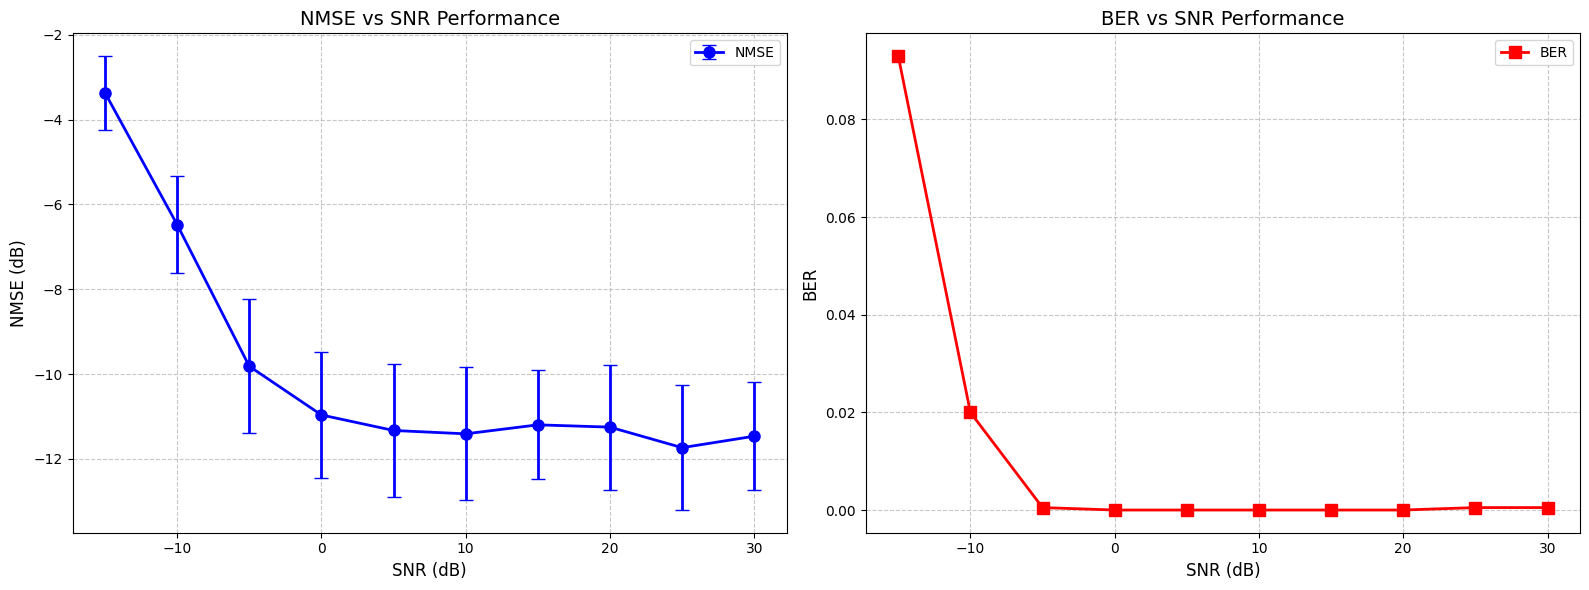

In [101]:
# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

snr = list(NMSE_mean_dict.keys())
nmse = list(NMSE_mean_dict.values())
std_dev = list(NMSE_std_dict.values())  # Get list of standard deviations
ber = list(BER_dict.values())

# Plot NMSE with std dev error bars
ax1.errorbar(snr, nmse, 
             yerr=std_dev,  # Simply use the standard deviation values
             marker='o', linestyle='-', linewidth=2, markersize=8,
             color='blue', label='NMSE', capsize=5)
ax1.set_xlabel('SNR (dB)', fontsize=12)
ax1.set_ylabel('NMSE (dB)', fontsize=12)
ax1.set_title('NMSE vs SNR Performance', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.grid(True, which='minor', linestyle=':', alpha=0.4)
ax1.legend()

# Plot BER (unchanged)
ax2.plot(snr, ber, marker='s', linestyle='-', linewidth=2, markersize=8, 
         color='red', label='BER')
ax2.set_xlabel('SNR (dB)', fontsize=12)
ax2.set_ylabel('BER', fontsize=12)
ax2.set_title('BER vs SNR Performance', fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.grid(True, which='minor', linestyle=':', alpha=0.4)
ax2.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()